# Regime-Aware Credit PD Pipeline

This notebook follows step-by-step instructions from README.md to build a regime-aware credit probability of default (PD) modeling pipeline.

## Outline
1. Read README.md File
2. Parse Instructions from README.md
3. Execute Instructions Programmatically

In [ ]:
# Section 1: Read README.md File
with open('README.md', 'r', encoding='utf-8') as f:
    readme_content = f.read()
print(readme_content[:1000])  # Print first 1000 characters for preview

In [ ]:
# Section 2: Parse Instructions from README.md
import re

# Extract step instructions from README.md
steps = re.findall(r'\u{1F4C8}|\u{1F4C9}|\u{1F4C7}|\u{1F4C6}|\u{1F4C5}|\u{1F4C4}|\u{1F4C3}|\u{1F4C2}|\u{1F4C1}|\u{1F4C0}|STEP \d+.*?(?=\n\n|\n\u{1F4C8}|\n\u{1F4C9}|\n\u{1F4C7}|\n\u{1F4C6}|\n\u{1F4C5}|\n\u{1F4C4}|\n\u{1F4C3}|\n\u{1F4C2}|\n\u{1F4C1}|\n\u{1F4C0}|$)', readme_content, re.DOTALL)

if not steps:
    # Fallback: split by 'STEP' if emoji fails
    steps = re.split(r'(?=STEP \d+)', readme_content)

for i, step in enumerate(steps):
    print(f"\n--- Step {i+1} ---\n{step[:500]}")

## Section 3: Execute Instructions Programmatically

The following cells will implement each step from the README.md instructions, including environment setup, data loading, HMM fitting, merging, modeling, calibration, and comparison.

In [21]:
# STEP 0 — Setup Environment
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from hmmlearn.hmm import GaussianHMM
import xgboost as xgb

print('Environment setup complete. Libraries imported.')

Environment setup complete. Libraries imported.


In [5]:
# STEP 1 — Load Borrower Dataset
# For prototype, generate synthetic borrower-level data aligned to available macro years
np.random.seed(42)
BORROWER_START_YEAR = 2000
years = pd.date_range(f'{BORROWER_START_YEAR}-12-31', f'{pd.Timestamp.today().year}-12-31', freq='YE')
obs_per_year = 40
dates = np.repeat(years.values, obs_per_year)
num_records = len(dates)

borrower_df = pd.DataFrame({
    'date': dates,
    'leverage': np.random.normal(2, 0.5, num_records),
    'interest_coverage': np.random.normal(5, 1.5, num_records),
    'asset_growth': np.random.normal(0.05, 0.02, num_records),
    'default': np.random.binomial(1, 0.08, num_records)
})

borrower_df['date'] = pd.to_datetime(borrower_df['date'])
borrower_df = borrower_df.sort_values('date')
print(borrower_df.head())

         date  leverage  interest_coverage  asset_growth  default
0  2000-12-31  2.248357           4.477022      0.027771        0
22 2000-12-31  2.033764           8.132562      0.046392        0
23 2000-12-31  1.287626           4.790616      0.077457        0
24 2000-12-31  1.727809           6.662274      0.005763        0
25 2000-12-31  2.055461           3.440141      0.080669        0


In [25]:
# STEP 2 — Load Real Macroeconomic Data from World Bank API
COUNTRY_CODE = 'US'
WORLD_BANK_INDICATORS = {
    'gdp_growth': 'NY.GDP.MKTP.KD.ZG',       # GDP growth (annual %)
    'unemployment': 'SL.UEM.TOTL.ZS',        # Unemployment, total (% of labor force)
    'interest_rate': 'FR.INR.LEND'           # Lending interest rate (%)
}

def fetch_world_bank_indicator(country_code: str, indicator_code: str) -> pd.DataFrame:
    url = f'https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}'
    params = {'format': 'json', 'per_page': 20000}
    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()

    if len(payload) < 2 or payload[1] is None:
        raise ValueError(f'No data returned for indicator {indicator_code}.')

    rows = [
        {'date': pd.to_datetime(f"{item['date']}-12-31"), 'value': item['value']}
        for item in payload[1]
        if item.get('value') is not None
    ]
    return pd.DataFrame(rows).sort_values('date').reset_index(drop=True)

macro_df = None
for col, indicator in WORLD_BANK_INDICATORS.items():
    indicator_df = fetch_world_bank_indicator(COUNTRY_CODE, indicator).rename(columns={'value': col})
    macro_df = indicator_df if macro_df is None else macro_df.merge(indicator_df, on='date', how='inner')

macro_df = macro_df.sort_values('date').reset_index(drop=True)
macro_df = macro_df[(macro_df['date'] >= borrower_df['date'].min()) & (macro_df['date'] <= borrower_df['date'].max())]
macro_df = macro_df[macro_df['date'] >= pd.Timestamp(f'{BORROWER_START_YEAR}-12-31')]

if macro_df.empty:
    raise ValueError('Macro dataframe is empty after date alignment. Check country code or date range.')

print(f'Loaded {len(macro_df)} yearly observations from World Bank for {COUNTRY_CODE}.')
print(f"Macro timeframe: {macro_df['date'].min().date()} to {macro_df['date'].max().date()}")
print(macro_df.head())

Loaded 22 yearly observations from World Bank for US.
Macro timeframe: 2000-12-31 to 2021-12-31
         date  gdp_growth  unemployment  interest_rate
9  2000-12-31    4.077586         3.992       9.233333
10 2001-12-31    0.955538         4.731       6.921667
11 2002-12-31    1.700447         5.783       4.675000
12 2003-12-31    2.795606         5.989       4.122500
13 2004-12-31    3.847772         5.529       4.340000


In [26]:
# STEP 3 — Fit Hidden Markov Model
from sklearn.preprocessing import StandardScaler

macro_vars = ['gdp_growth', 'unemployment', 'interest_rate']
scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_df[macro_vars])

hmm = GaussianHMM(n_components=3, covariance_type='full', random_state=42)
hmm.fit(macro_scaled)
macro_df['regime'] = hmm.predict(macro_scaled)

print('Transition matrix:')
print(hmm.transmat_)

print('Average macro values per regime:')
print(macro_df.groupby('regime')[macro_vars].mean())

Model is not converging.  Current: -58.2572660228149 is not greater than -58.25726174196858. Delta is -4.280846326309984e-06


Transition matrix:
[[1.88123699e-04 9.99811840e-01 3.66553229e-08]
 [5.87306655e-01 7.52117055e-07 4.12692593e-01]
 [1.77927675e-17 9.26812524e-02 9.07318748e-01]]
Average macro values per regime:
        gdp_growth  unemployment  interest_rate
regime                                         
0         2.417726         6.008       6.382083
1         1.086171         6.528       5.532167
2         2.456890         5.722       3.902821


In [29]:
# STEP 4 — Merge Regime with Borrower Data
# Make this cell idempotent for repeated notebook runs
regime_cols = [col for col in borrower_df.columns if col.startswith('regime')]
if regime_cols:
    borrower_df = borrower_df.drop(columns=regime_cols)

borrower_df = borrower_df.merge(
    macro_df[['date', 'regime']],
    on='date',
    how='inner',
    validate='many_to_one'
 )
borrower_df = borrower_df.sort_values('date').reset_index(drop=True)
print(f"Post-merge borrower timeframe: {borrower_df['date'].min().date()} to {borrower_df['date'].max().date()}")
print(f'Rows after strict date alignment: {len(borrower_df)}')
print(borrower_df.head())

Post-merge borrower timeframe: 2000-12-31 to 2021-12-31
Rows after strict date alignment: 880
        date  leverage  interest_coverage  asset_growth  default  regime
0 2000-12-31  2.248357           4.477022      0.027771        0       0
1 2000-12-31  1.699147           4.713976      0.018038        0       0
2 2000-12-31  1.854153           7.871047      0.061771        0       0
3 2000-12-31  1.293848           5.519733      0.050136        0       0
4 2000-12-31  2.323844           4.517547      0.059964        0       0


Train timeframe: 2000-12-31 to 2014-12-31
Test timeframe: 2015-12-31 to 2021-12-31
Baseline Logistic Regression AUC: 0.452
Confusion Matrix:
[[257   0]
 [ 23   0]]


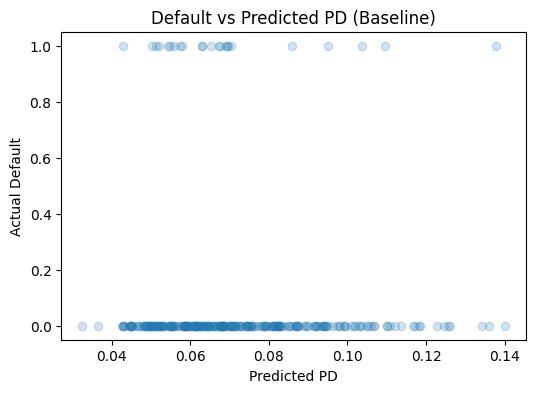

In [30]:
# STEP 5 — Train Baseline PD Model (No Regime)
features = ['leverage', 'interest_coverage', 'asset_growth']

# Split by date cutoff (not row cutoff) to avoid leakage across same dates
unique_dates = np.sort(borrower_df['date'].unique())
cutoff_idx = max(1, int(0.7 * len(unique_dates)) - 1)
cutoff_date = unique_dates[cutoff_idx]
train_df = borrower_df[borrower_df['date'] <= cutoff_date].copy()
test_df = borrower_df[borrower_df['date'] > cutoff_date].copy()

if test_df.empty:
    raise ValueError('Test set is empty after date split. Increase date range or adjust split.')

print(f'Train timeframe: {train_df["date"].min().date()} to {train_df["date"].max().date()}')
print(f'Test timeframe: {test_df["date"].min().date()} to {test_df["date"].max().date()}')

X_train = train_df[features]
y_train = train_df['default']
X_test = test_df[features]
y_test = test_df['default']

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_proba_lr = lr.predict_proba(X_test)[:, 1]
pred_lr = lr.predict(X_test)

auc_lr = roc_auc_score(y_test, pred_proba_lr)
cm_lr = confusion_matrix(y_test, pred_lr)

print(f'Baseline Logistic Regression AUC: {auc_lr:.3f}')
print('Confusion Matrix:')
print(cm_lr)

# Calibration check
plt.figure(figsize=(6,4))
plt.scatter(pred_proba_lr, y_test, alpha=0.2)
plt.xlabel('Predicted PD')
plt.ylabel('Actual Default')
plt.title('Default vs Predicted PD (Baseline)')
plt.show()

In [31]:
# STEP 6 — Train Regime-Aware PD Model (XGBoost)
from sklearn.preprocessing import LabelEncoder

if 'regime' not in borrower_df.columns:
    if 'macro_df' in globals() and 'regime' in macro_df.columns:
        borrower_df = borrower_df.merge(macro_df[['date', 'regime']], on='date', how='inner')
        borrower_df = borrower_df.sort_values('date').reset_index(drop=True)
    else:
        raise ValueError("'regime' is missing. Run STEP 3 and STEP 4 first.")

if 'cutoff_date' not in globals():
    unique_dates = np.sort(borrower_df['date'].unique())
    cutoff_idx = max(1, int(0.7 * len(unique_dates)) - 1)
    cutoff_date = unique_dates[cutoff_idx]

regime_encoder = LabelEncoder()
borrower_df['regime_cat'] = regime_encoder.fit_transform(borrower_df['regime'])

# Ensure 'regime_cat' is present in train/test splits
df_with_regime = borrower_df.copy()
train_df = df_with_regime[df_with_regime['date'] <= cutoff_date].copy()
test_df = df_with_regime[df_with_regime['date'] > cutoff_date].copy()

features_regime = features + ['regime_cat']
X_train_regime = train_df[features_regime]
X_test_regime = test_df[features_regime]

y_train = train_df['default']
y_test = test_df['default']

xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_regime, y_train)
pred_proba_xgb = xgb_model.predict_proba(X_test_regime)[:, 1]
pred_xgb = xgb_model.predict(X_test_regime)

auc_xgb = roc_auc_score(y_test, pred_proba_xgb)
print(f'Regime-Aware XGBoost AUC: {auc_xgb:.3f}')

Regime-Aware XGBoost AUC: 0.557


f:\Projects\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:23:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
# STEP 7 — Add Monotonic Constraints
# Ensure monotone_constraints matches the number/order of features in features_regime
monotone_constraints = (1, -1, 0, 0)  # leverage (increasing), interest_coverage (decreasing), asset_growth (none), regime_cat (none)

xgb_monotone = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=100, monotone_constraints=monotone_constraints, use_label_encoder=False, eval_metric='logloss')
xgb_monotone.fit(X_train_regime, y_train)
pred_proba_xgb_monotone = xgb_monotone.predict_proba(X_test_regime)[:, 1]
auc_xgb_monotone = roc_auc_score(y_test, pred_proba_xgb_monotone)
print(f'Monotone XGBoost AUC: {auc_xgb_monotone:.3f}')

Monotone XGBoost AUC: 0.539


f:\Projects\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:23:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


f:\Projects\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
f:\Projects\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
f:\Projects\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


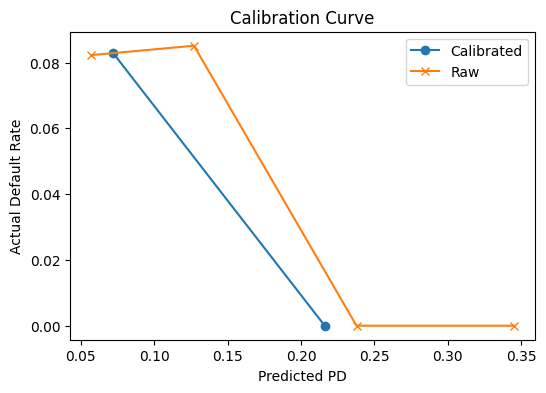

Calibrated XGBoost AUC: 0.488


In [33]:
# STEP 8 — Probability Calibration
# Fit calibration on training data only; evaluate on untouched test data
calibrator = CalibratedClassifierCV(xgb_monotone, method='isotonic', cv=3)
calibrator.fit(X_train_regime, y_train)
pred_proba_calibrated = calibrator.predict_proba(X_test_regime)[:, 1]

# Calibration curve
plt.figure(figsize=(6,4))
prob_true, prob_pred = calibration_curve(y_test, pred_proba_calibrated, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
prob_true_raw, prob_pred_raw = calibration_curve(y_test, pred_proba_xgb_monotone, n_bins=10)
plt.plot(prob_pred_raw, prob_true_raw, marker='x', label='Raw')
plt.xlabel('Predicted PD')
plt.ylabel('Actual Default Rate')
plt.title('Calibration Curve')
plt.legend()
plt.show()

auc_calibrated = roc_auc_score(y_test, pred_proba_calibrated)
print(f'Calibrated XGBoost AUC: {auc_calibrated:.3f}')

In [34]:
# STEP 9 — Compare Results
results = pd.DataFrame({
    'Model': ['Baseline Logistic', 'XGBoost', 'Monotone XGBoost', 'Calibrated XGBoost'],
    'AUC': [auc_lr, auc_xgb, auc_xgb_monotone, auc_calibrated],
    'Brier': [
        brier_score_loss(y_test, pred_proba_lr),
        brier_score_loss(y_test, pred_proba_xgb),
        brier_score_loss(y_test, pred_proba_xgb_monotone),
        brier_score_loss(y_test, pred_proba_calibrated)
    ],
    'LogLoss': [
        log_loss(y_test, pred_proba_lr),
        log_loss(y_test, pred_proba_xgb),
        log_loss(y_test, pred_proba_xgb_monotone),
        log_loss(y_test, pred_proba_calibrated)
    ],
    'Comments': ['No regime', 'With regime', 'With regime + monotonic', 'With regime + monotonic + calibration']
})
print('AUC higher is better; Brier/LogLoss lower is better.')
print(results)


AUC higher is better; Brier/LogLoss lower is better.
                Model       AUC     Brier   LogLoss  \
0   Baseline Logistic  0.451869  0.076235  0.290634   
1             XGBoost  0.557266  0.075550  0.288357   
2    Monotone XGBoost  0.539249  0.076453  0.288797   
3  Calibrated XGBoost  0.488496  0.075982  0.286692   

                                Comments  
0                              No regime  
1                            With regime  
2                With regime + monotonic  
3  With regime + monotonic + calibration  


In [35]:
# STEP 10 — Print Insights
print('Regime transition matrix:')
print(hmm.transmat_)

print('Default rate per regime:')
default_rate_per_regime = borrower_df.groupby('regime')['default'].mean()
print(default_rate_per_regime)

print('Model comparison (AUC, Brier, LogLoss):')
print(results)

print('Feature importance from XGBoost:')
importances = xgb_model.feature_importances_
for feat, imp in zip(features_regime, importances):
    print(f'{feat}: {imp:.3f}')

print('Feature importance from Monotone XGBoost:')
importances_monotone = xgb_monotone.feature_importances_
for feat, imp in zip(features_regime, importances_monotone):
    print(f'{feat}: {imp:.3f}')

Regime transition matrix:
[[1.88123699e-04 9.99811840e-01 3.66553229e-08]
 [5.87306655e-01 7.52117055e-07 4.12692593e-01]
 [1.77927675e-17 9.26812524e-02 9.07318748e-01]]
Default rate per regime:
regime
0    0.050000
1    0.100000
2    0.073077
Name: default, dtype: float64
Model comparison (AUC, Brier, LogLoss):
                Model       AUC     Brier   LogLoss  \
0   Baseline Logistic  0.451869  0.076235  0.290634   
1             XGBoost  0.557266  0.075550  0.288357   
2    Monotone XGBoost  0.539249  0.076453  0.288797   
3  Calibrated XGBoost  0.488496  0.075982  0.286692   

                                Comments  
0                              No regime  
1                            With regime  
2                With regime + monotonic  
3  With regime + monotonic + calibration  
Feature importance from XGBoost:
leverage: 0.313
interest_coverage: 0.253
asset_growth: 0.225
regime_cat: 0.209
Feature importance from Monotone XGBoost:
leverage: 0.337
interest_coverage: 0.205